In [25]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import edhec_risk_kit as erk

# load
ind_return = erk.get_ind_returns()
tmi_return = erk.get_total_market_index_returns()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Implementing CPPI and Drawdown Constraints

1. Compute the cushion (A - F)
2. Compute the allocation (m*cushion for risky asset)
3. Compute the new asset value (risk_asset*risky_return + safe_asset*safe_return)

In [45]:
risky_r = ind_return['2000':][["Steel","Fin", "Beer"]]
# Assuming the safe asset is paying 3% per year 
safe_r = pd.DataFrame().reindex_like(risky_r)  # .reindex_like to make sure that safe asset return (safe_r) has the same shape as risk_r
safe_r.values[:] = 0.03/12 # set all values to a number
start = 1000 # starting with $1000
floor = 0.8 # 80% of the starting vlaue is the floor

# CPPI parameters
dates = risky_r.index
n_steps = len(dates)
account_value = start
floor_value = start*floor
m=3
## use DataFrame for saving intermediate values
account_history = pd.DataFrame().reindex_like(risky_r)
cushion_history = pd.DataFrame().reindex_like(risky_r)
risky_weight_history = pd.DataFrame().reindex_like(risky_r)


In [46]:
for step in range(n_steps):
    cushion = (account_value - floor_value)/account_value # in percentage
    risky_weight = m*cushion
    risky_weight =np.minimum(risky_weight,1) #compare risky_weight within 1 and return the smaller one, thus constrain risky_weight <1
    risky_weight =np.maximum(risky_weight,0)
    safe_weight = 1- risky_weight
    risky_alloc = account_value*risky_weight
    safe_alloc = account_value*safe_weight
    
    # Update the account value for this time step
    account_value = risky_alloc*(1+risky_r.iloc[step]) + safe_alloc*(1+safe_r.iloc[step])
    
    # save the values so as to track the history
    cushion_history.iloc[step] = cushion
    risky_weight_history.iloc[step] = risky_weight
    account_history.iloc[step] = account_value
    risky_wealth = start*(1+risky_r).cumprod()
 

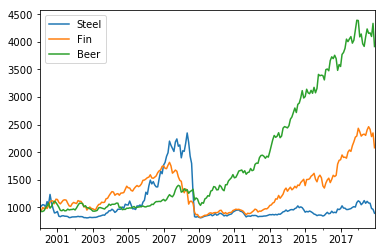

In [47]:
account_history.plot()

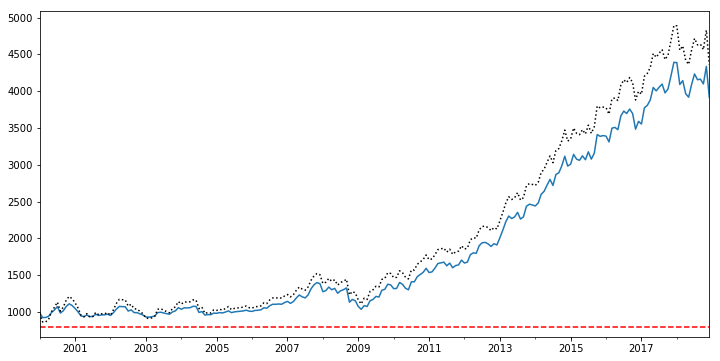

In [51]:
ind='Beer'
ax = account_history[ind].plot(figsize=(12,6))
risky_wealth[ind].plot(style='k:')
ax.axhline(y=floor_value, color='r',linestyle='--')

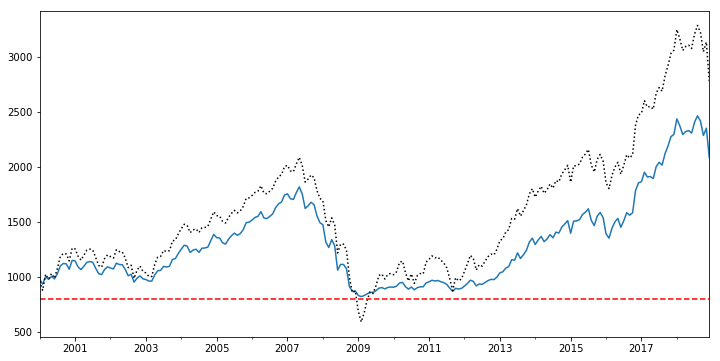

In [50]:
ind='Fin'
ax = account_history[ind].plot(figsize=(12,6))
risky_wealth[ind].plot(style='k:')
ax.axhline(y=floor_value, color='r',linestyle='--')


Advantage: no violation of the floor when CPPI strategy is used;
Downside: not that gain when the market is getting better

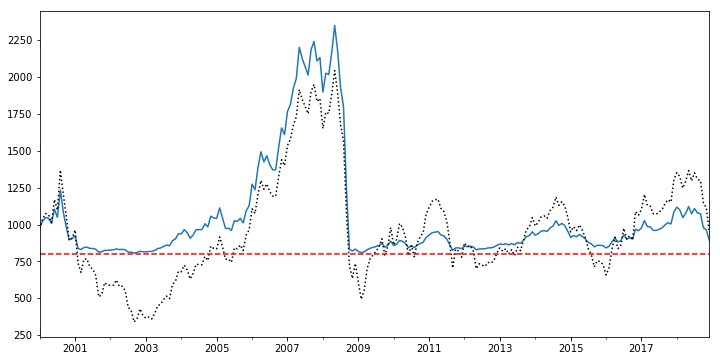

In [54]:
ind='Steel'
ax = account_history[ind].plot(figsize=(12,6))
risky_wealth[ind].plot(style='k:')
ax.axhline(y=floor_value, color='r',linestyle='--')

The CPPI is much less volatile than non-dynamic hedged portfolio


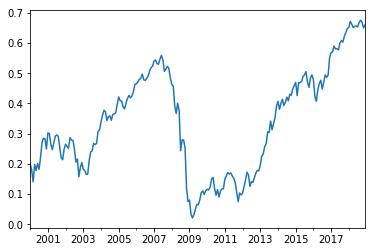

In [52]:
cushion_history["Fin"].plot()

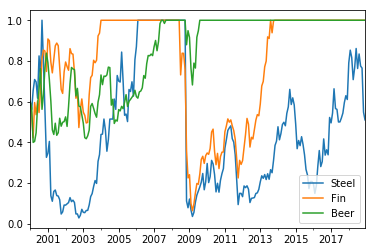

In [53]:
risky_weight_history.plot()

Let's put this into a new funciton named cppi

In [56]:
def run_cppi(risky_r, safe_r=None, m=3, start=1000, floor=0.8, riskfree_rate=0.03):
    """
    Run a backtest of the CPPI strategy, given a set of returns for the riksy asset
    Returns a dictionary containing: asset value history, risk budget history, riksy weight history
    """
    # CPPI parameters
    dates = risky_r.index
    n_steps = len(dates)
    account_value = start
    floor_value = start*floor
    
    if isinstance(risky_r, pd.Series):
        risky_r = pd.DataFrame(risky_r, columns=['R'])
        
    if safe_r is None:
        safe_r = pd.DataFrame.reindex_like(risky_r)
        safe_r.values[:] = riskfree_rate/12  

    ## use DataFrame for saving intermediate values
    account_history = pd.DataFrame().reindex_like(risky_r)
    cushion_history = pd.DataFrame().reindex_like(risky_r)
    risky_weight_history = pd.DataFrame().reindex_like(risky_r)
    
    for step in range(n_steps):
        cushion = (account_value - floor_value)/account_value # in percentage
        risky_weight = m*cushion
        risky_weight =np.minimum(risky_weight,1) #compare risky_weight within 1 and return the smaller one, thus constrain risky_weight <1
        risky_weight =np.maximum(risky_weight,0)
        safe_weight = 1- risky_weight
        risky_alloc = account_value*risky_weight
        safe_alloc = account_value*safe_weight
    
    # Update the account value for this time step
    account_value = risky_alloc*(1+risky_r.iloc[step]) + safe_alloc*(1+safe_r.iloc[step])
    
    # save the values so as to track the history
    cushion_history.iloc[step] = cushion
    risky_weight_history.iloc[step] = risky_weight
    account_history.iloc[step] = account_value
    risky_wealth = start*(1+risky_r).cumprod()



IndentationError: expected an indented block (<ipython-input-56-ffb7bffedef5>, line 25)

In [58]:
btr = erk.run_cppi(risky_r)

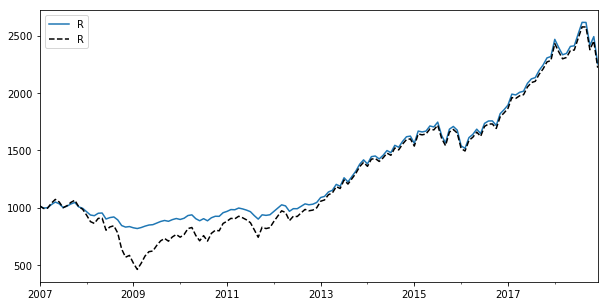

In [62]:
btr = erk.run_cppi(tmi_return['2007':])
ax = btr['Wealth'].plot(legend=True, figsize=(10,5),label = 'CPPI')
btr["Risky Wealth"].plot(ax = ax, style="k--", legend=True, label = 'Risky Wealth')

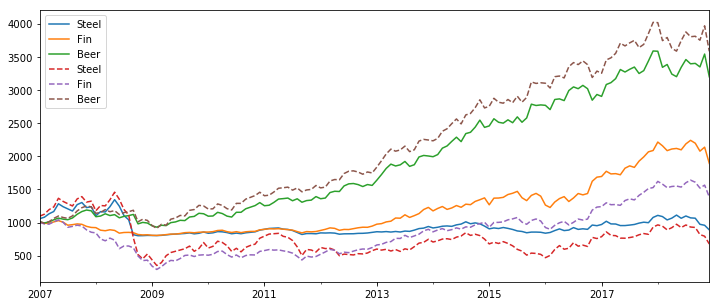

In [63]:
btr = erk.run_cppi(ind_return["2007":][["Steel", "Fin", "Beer"]])
ax = btr["Wealth"].plot(figsize=(12,5))
btr["Risky Wealth"].plot(ax=ax, style="--")

In [66]:
erk.summary_stats(btr["Wealth"].pct_change().dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Steel,-0.014490,0.126906,-1.554266,11.668243,0.068652,0.098467,-0.341351,-0.404132
Fin,0.054690,0.109579,-0.254976,5.589082,0.047503,0.068951,0.219159,-0.216868
Beer,0.101518,0.114363,-0.743585,4.527865,0.051074,0.069081,0.608531,-0.217280


In [67]:
erk.summary_stats(btr["Risky Wealth"].pct_change().dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Steel,-0.039660,0.306407,-0.459951,4.782828,0.152288,0.203837,-0.221642,-0.758017
Fin,0.027364,0.212204,-0.695200,4.621401,0.105744,0.149862,-0.012370,-0.718465
Beer,0.111554,0.127971,-0.670797,4.650878,0.056497,0.077388,0.620132,-0.271368


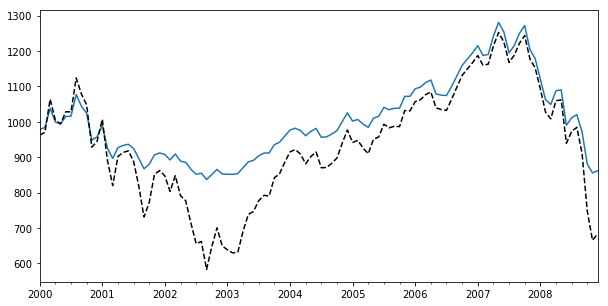

In [68]:
btr = erk.run_cppi(tmi_return["2000":"2008"])
ax = btr["Wealth"].plot(legend=False, figsize=(10, 5))
btr["Risky Wealth"].plot(ax = ax, style="k--", legend=False)

Insurance strategies usually help with drawdowns, but they can also be adapted to explictly limit the drawdown.

# Improve CPPI by adding a drawdown constraint

In [75]:
btr  = erk.run_cppi(ind_return["2007":][['Steel','Fin','Beer']], drawdown = 0.25)

In [76]:
erk.summary_stats(btr["Wealth"].pct_change().dropna())[["Annualized Return", "Annualized Vol", "Sharpe Ratio", "Max Drawdown"]]

,Annualized Return,Annualized Vol,Sharpe Ratio,Max Drawdown
Steel,0.003784,0.097073,-0.262958,-0.248059
Fin,0.041975,0.085028,0.136964,-0.243626
Beer,0.084375,0.086263,0.613413,-0.161186


In [77]:
erk.summary_stats(btr["Risky Wealth"].pct_change().dropna())[["Annualized Return", "Annualized Vol", "Sharpe Ratio", "Max Drawdown"]]

,Annualized Return,Annualized Vol,Sharpe Ratio,Max Drawdown
Steel,-0.039660,0.306407,-0.221642,-0.758017
Fin,0.027364,0.212204,-0.012370,-0.718465
Beer,0.111554,0.127971,0.620132,-0.271368
